# Adaboost and Visualization

# AdaBoost


1)&emsp;For every sample（$x_{1},x_{2},….,x_{N}$）, initialize all the weights uniformly, $w_{i}$=1/N for all i;

For t = 1, . . . , T:

{
    
2)&emsp;Fit the weak classiﬁer $G_t$ to the current weighted training set;
    
3)&emsp;Compute Weighted Error Rate for $G_t$ using $e_t=\sum_{i=1}^Nw_{i,t}I(y_i\not= G_t(x_i))$;

4)&emsp;Compute $G_t$'s weight $\alpha_t=0.5\log[(1-e_t)/e_t]$

5)&emsp;Update the weights as follows:$w_{i,t+1} = w_{i,t}exp({-α{G_{t}(x_{i})y(i) }})/Z_t$, where $Z_t=\sum_{i=1}^Nw_{i,t}$ 


}

6)&emsp;Compute the final predictions as: $f(x)=sign(\sum_{t=1}^T\alpha_tG_t(x_i))$

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import copy
%matplotlib inline

## data preprocessing

In [2]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    #print(df.head(100))
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [3]:
X, y = create_data()
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Text(0, 0.5, 'sepal width')

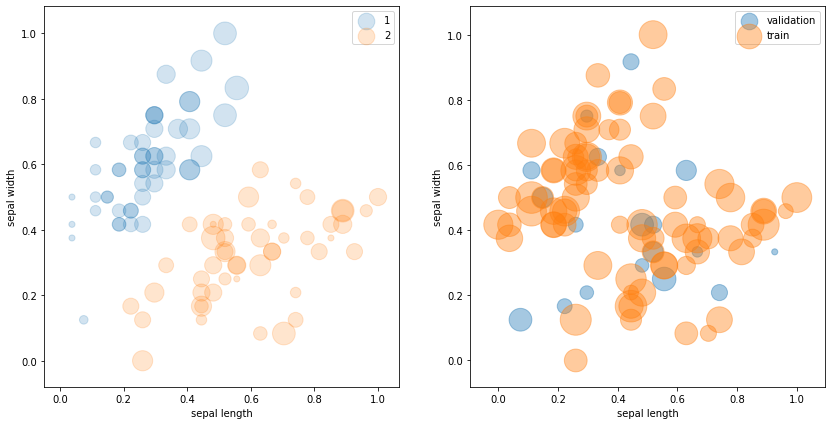

In [7]:
X_norm = np.array([(X[k,0]-min(X[:,0]))/(max(X[:,0])-min(X[:,0])) for k in range(X.shape[0])])
map_color = {-1: 'r', 1: 'g'}
color_test = list(map(lambda x: map_color[x], y_test))
color_train = list(map(lambda x: map_color[x], y_train))
fig = plt.figure(figsize = [14,7])
ax1=plt.subplot(121)
ax1.scatter(X[:50,0],X[:50,1],alpha=0.2, label='1',s=1000*(X_norm[:50]))
ax1.scatter(X[50:,0],X[50:,1],alpha=0.2, label='2',s=1000*(X_norm[:50]))
ax1.legend()
plt.xlabel("sepal length")
plt.ylabel("sepal width")
ax2=plt.subplot(122)
ax2.scatter(X_test[:,0],X_test[:,1],alpha=0.4, label='validation',s = 1000*X_norm[:50])
ax2.scatter(X_train[:,0],X_train[:,1],alpha=0.4, label='train',s = 1000*X_norm[50:])
ax2.legend()
plt.xlabel("sepal length")
plt.ylabel("sepal width")

----

### AdaBoost in Python

In [22]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_interval=1.0,mute=True,learning_rate=1.0):
        self.clf_num = n_estimators
        self.learning_interval = learning_interval
        self.mute = mute
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        
        # weak classifier sets
        self.clf_sets = []
        
        # initialize weights of every sample
        self.weights = [1.0/self.M]*self.M
        
        # G(x)‘s weights’ alpha
        self.alpha = []
        
    def _G(self, features, labels, weights):
        m = len(features)
        error = 100000.0 # infinity
        best_v = 0.0
        best_d = None
        # single dimension features
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max - features_min + self.learning_interval) // self.learning_interval
        # print('n_step:{}'.format(n_step))
        direct, compare_array = None, None
        for i in range(1, int(n_step)):
            v = features_min + self.learning_interval * i
            
            if v not in features:
                # calculate the error for every threshold
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)])
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k] != labels[k]])
                
                compare_array_negative = np.array([-1 if features[k] > v else 1 for k in range(m)])
                weight_error_negative = sum([weights[k] for k in range(m) if compare_array_negative[k] != labels[k]])

                #print('weight_error_positive:{} weight_error_negative:{} v:{}'.format(
                #     weight_error_positive,weight_error_negative,v))
                if weight_error_positive < weight_error_negative:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_negative
                    _compare_array = compare_array_negative
                    direct = 'negative'
                    
                
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
                    best_d = direct
        #print('v:{} error:{} d:{}'.format(best_v, error,best_d))
        return best_v, best_d, error, compare_array
        
    # weights for every classifier
    def _alpha(self, error):
        return 0.5 * np.log((1-error)/error)*self.learning_rate
    
    # normalization index Z
    def _Z(self, weights, a, clf):
        return sum([weights[i]*np.exp(-1*a*self.Y[i]*clf[i]) for i in range(self.M)])
        
    # update the weights for every sample
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i]*np.exp(-1*a*self.Y[i]*clf[i])/ Z
    
    # linear combination of G(x)
    def _f(self, alpha, clf_sets):
        pass
    
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1 
        else:
            return -1 if x > v else 1 
    
    def fit(self, X, y, max_declining_value = 1, early_stopping_value = 1):
        self.init_args(X, y)
        map_color = {-1: 'r', 1: 'b'}
        map_marker = {-1: 'x', 1: 'o'}
        last_score = self.score(X,y)
        current_score = self.score(X,y)
        prev_weights = [1.0/self.M]*self.M

        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None

            # search every dimension, choose the one with minimum error
            for j in range(self.N):
                features = self.X[:, j]
                # classifier threshold，error，classifier result
                v, direct, error, compare_array = self._G(features, self.Y, self.weights)
                
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j
                    
                # print('epoch:{}/{} feature:{} error:{} v:{}'.format(epoch, self.clf_num, j, error, best_v))
                if best_clf_error == 0:
                    break
            
            
            # calculate classifier weights a for G(x)
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            # append the classifier into the set
            self.clf_sets.append((axis, best_v, final_direct))
            #print('Clf_num={} axis={} best_v={} final_direct={} a_len={}'.format(
            #    len(self.clf_sets),axis, best_v, final_direct,len(self.alpha)))
            prev_weights = copy.deepcopy(self.weights)
            
            # update the normalization index Z
            Z = self._Z(self.weights, a, clf_result)
            # update weights for every sample
            self._w(a, clf_result, Z)
            
            if self.mute!=True:
                #draw the chart
                #print(prev_weights)
                we = sum([prev_weights[k] for k in range(len(y)) if clf_result[k] != y[k]])
                e = sum([1 for k in range(len(y)) if clf_result[k] != y[k]])/len(y)
                n = sum([1 for k in range(len(y)) if clf_result[k] != y[k]])
                print('epoch {}: a = {:.3f} weighted error rate={:.3f}'.format(epoch+1,a,we))
                color = list(map(lambda x: map_color[x], clf_result))
                markers = list(map(lambda x: map_marker[x], np.array([-1 if clf_result[k] != y[k] else 1 for k in range(self.M)])))
                size = self.size_calcu(self.weights)
                for _m,_s,_c,_x1,_x2 in zip(markers,size,color,self.X[:,0],X[:,1]):
                    plt.scatter(_x1,_x2,alpha=0.5, label='0',s=_s,c=_c,marker=_m)
                if axis == 0:
                    plt.plot([best_v,best_v],[min(self.X[:,1]),max(self.X[:,1])])
                else:
                    plt.plot([min(self.X[:,0]),max(self.X[:,0])],[best_v,best_v])
                plt.xlabel("sepal length")
                plt.ylabel("sepal width")
                #plt.legend()
                plt.pause(0.05)
            current_score = self.score(X,y)
            #print('last:{} current{}'.format(last_score,current_score))
            if (last_score-current_score > max_declining_value) or (last_score>=early_stopping_value and last_score-current_score>0):
                self.clf_sets=self.clf_sets[:-1]
                break
            else:
                last_score = current_score
        #plt.show()
#             print('classifier:{}/{} error:{:.3f} v:{} direct:{} a:{:.5f}'.format(epoch+1, self.clf_num, error, best_v, final_direct, a))
#             print('weight:{}'.format(self.weights))
#             print('\n')

    def size_calcu(self, weights):
        W = np.array(weights)
        W_norm = np.array([(W[k]-min(W[:]))/(max(W[:])-min(W[:])) for k in range(len(W))])
        return W_norm*1000+10
    
    def predict(self, feature,num_clf = None):
        if num_clf == None:
            num_clf = len(self.clf_sets)
        else:
            num_clf = min(len(self.clf_sets),num_clf)
        result = 0.0
        for i in range(0,num_clf):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
            #print(result)
        # sign
        return 1 if result > 0 else -1
    
    def score(self, X_test, y_test, num_clf = None):
        if num_clf == None:
            num_clf = len(self.clf_sets)
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature,num_clf = num_clf) == y_test[i]:
                right_count += 1
        return right_count / len(y_test)
    
    def history(self, X_train,y_train, X_test, y_test):
        H_train = []
        H_test = []
        for i in range(len(self.clf_sets)+1):
            H_train.append(self.score(X_train, y_train,i))
            H_test.append(self.score(X_test,y_test,i))
        plt.plot(range(len(H_train)),H_train,label = 'train')
        plt.plot(range(len(H_test)),H_test,label = 'test')
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.show()
        
    def get_clf(test,num):
        axis, clf_v, direct = self.clf_sets[num]
        result = []
        for i in range(len(test)):
            f_input = test[i,:][axis]
            result.append(self.alpha[num] * self.G(f_input, clf_v, direct))
        return result

epoch 1: a = 0.918 weighted error rate=0.137


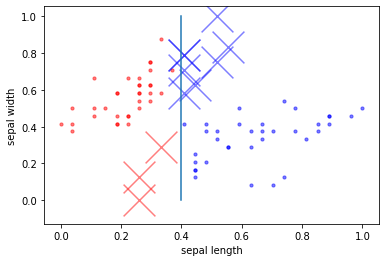

epoch 2: a = 1.091 weighted error rate=0.101


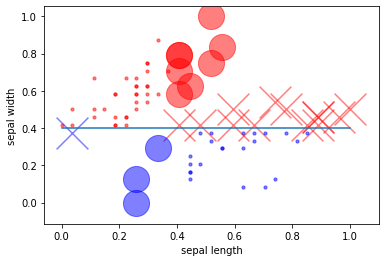

epoch 3: a = 0.884 weighted error rate=0.146


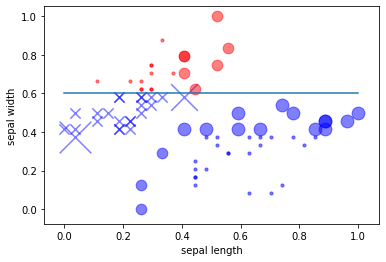

epoch 4: a = 0.879 weighted error rate=0.147


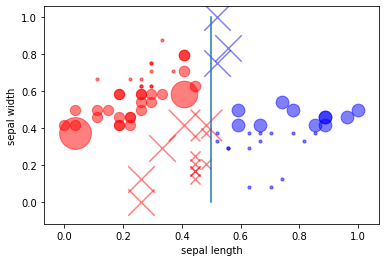

epoch 5: a = 0.440 weighted error rate=0.293


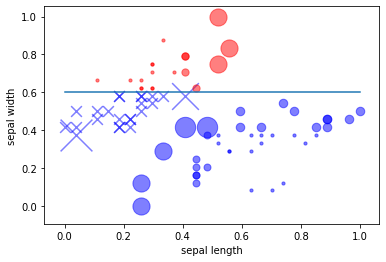

In [23]:
clf = AdaBoost(n_estimators=5, learning_interval=0.1,mute=False,learning_rate = 1)
clf.fit(X_train, y_train)

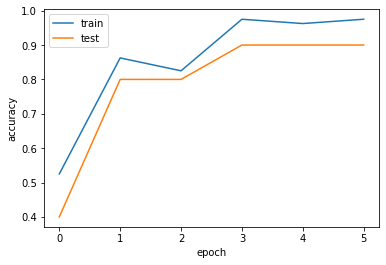

0.9

In [24]:
clf.history(X_train,y_train,X_test, y_test)
clf.score(X_test, y_test)

# Use of learning rate

In [241]:
clf = AdaBoost(n_estimators=100, learning_interval=0.1,mute=True,learning_rate = 0.1)
clf.fit(X_train, y_train)

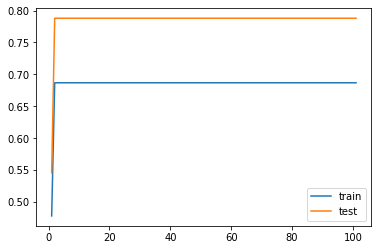

0.7878787878787878

In [217]:
clf.history(X_train,y_train,X_test, y_test)
clf.score(X_test, y_test)

In [218]:
clf = AdaBoost(n_estimators=100, learning_interval=0.1,mute=True,learning_rate = 1)
clf.fit(X_train, y_train)

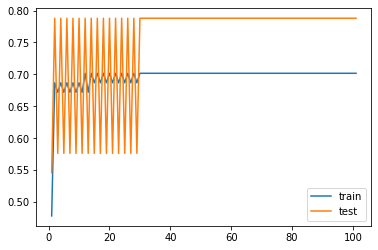

0.7878787878787878

In [219]:
clf.history(X_train,y_train,X_test, y_test)
clf.score(X_test, y_test)

### a problem of Adaboost (I found out later that this was caused by a bug, so these two hyperparameters are no longer necessary)
sometimes the accuracy goes down as the number of estimators increases

score:0.939


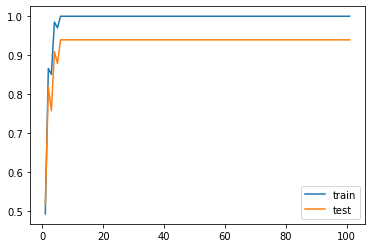

In [240]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = AdaBoost(n_estimators=100, learning_interval=0.1)
clf.fit(X_train, y_train)
print('score:{:.3f}'.format(clf.score(X_test, y_test)))
clf.history(X_train,y_train,X_test, y_test)

### Add two hyperparameter for early stopping

In [7]:
clf = AdaBoost(n_estimators=100, learning_interval=0.1,mute=True)
clf.fit(X_train, y_train,max_declining_value = 0.1, early_stopping_value = 0.88)
clf.score(X_test, y_test)

0.9090909090909091

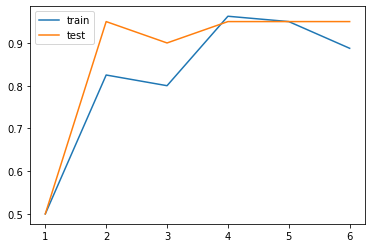

In [26]:
clf.history(X_train,y_train,X_test, y_test)

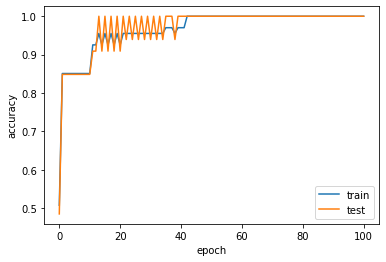

1.0

In [60]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = AdaBoost(n_estimators=100, learning_interval=0.1,mute=True,learning_rate = 0.1)
clf.fit(X_train, y_train)
clf.history(X_train,y_train,X_test, y_test)
clf.score(X_test, y_test)

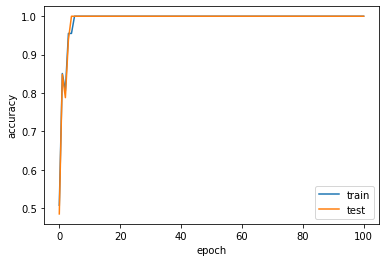

1.0

In [61]:
clf = AdaBoost(n_estimators=100, learning_interval=0.1,mute=True,learning_rate = 1)
clf.fit(X_train, y_train)
clf.history(X_train,y_train,X_test, y_test)
clf.score(X_test, y_test)

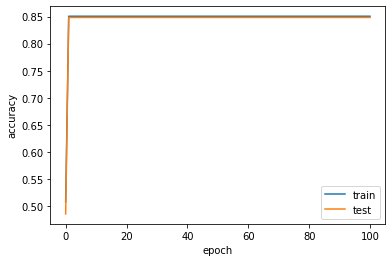

0.8484848484848485

In [62]:
clf = AdaBoost(n_estimators=100, learning_interval=0.1,mute=True,learning_rate = 0.01)
clf.fit(X_train, y_train)
clf.history(X_train,y_train,X_test, y_test)
clf.score(X_test, y_test)

### use early stopping

In [26]:
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost(n_estimators=100, learning_interval=0.2)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))

1/100 score：0.8787878787878788
2/100 score：0.696969696969697
3/100 score：0.9090909090909091
4/100 score：1.0
5/100 score：0.9393939393939394
6/100 score：0.8181818181818182
7/100 score：0.7878787878787878
8/100 score：0.9090909090909091
9/100 score：0.8484848484848485
10/100 score：0.696969696969697
11/100 score：0.6060606060606061
12/100 score：0.7575757575757576
13/100 score：0.9393939393939394
14/100 score：0.7575757575757576
15/100 score：1.0
16/100 score：0.7878787878787878
17/100 score：0.7575757575757576
18/100 score：0.8787878787878788
19/100 score：0.9696969696969697
20/100 score：0.9696969696969697
21/100 score：0.696969696969697
22/100 score：0.9090909090909091
23/100 score：0.8181818181818182
24/100 score：0.8484848484848485
25/100 score：0.9090909090909091
26/100 score：0.9393939393939394
27/100 score：0.8787878787878788
28/100 score：0.7878787878787878
29/100 score：0.8484848484848485
30/100 score：0.9393939393939394
31/100 score：0.8787878787878788
32/100 score：0.9696969696969697
33/100 score：0.727

### without early stopping

In [25]:
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost(n_estimators=100, learning_interval=0.2,learning_rate = 0.1)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))

1/100 score：0.8181818181818182
2/100 score：1.0
3/100 score：1.0
4/100 score：0.9393939393939394
5/100 score：0.9393939393939394
6/100 score：0.7272727272727273
7/100 score：1.0
8/100 score：0.8787878787878788
9/100 score：0.7272727272727273
10/100 score：0.7575757575757576
11/100 score：0.8787878787878788
12/100 score：1.0
13/100 score：0.8181818181818182
14/100 score：0.6666666666666666
15/100 score：0.696969696969697
16/100 score：0.8181818181818182
17/100 score：0.7575757575757576
18/100 score：0.7272727272727273
19/100 score：0.6666666666666666
20/100 score：0.6666666666666666
21/100 score：0.6363636363636364
22/100 score：0.7878787878787878
23/100 score：0.8484848484848485
24/100 score：0.8484848484848485
25/100 score：0.9090909090909091
26/100 score：0.7878787878787878
27/100 score：0.9393939393939394
28/100 score：0.9696969696969697
29/100 score：0.9393939393939394
30/100 score：0.6666666666666666
31/100 score：0.7878787878787878
32/100 score：1.0
33/100 score：0.9090909090909091
34/100 score：0.78787878787878

-----
# sklearn.ensemble.AdaBoostClassifier

In [11]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train, y_train)

c:\programdata\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=None)

In [12]:
clf.score(X_test, y_test)

0.9393939393939394

In [90]:
pmdata = pd.read_csv('/Users/ggq/Desktop/Data/FiveCitiePMData/BeijingPM20100101_20151231.csv')

In [97]:
pmdata

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0


# Decision Tree based AdaBoost

In [64]:
class AdaBoost_DT:
    def __init__(self, n_estimators=50,mute=True):
        self.clf_num = n_estimators
        self.mute = mute
    
    def init_args(self, datasets, labels):
        
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        
        # weak classifier sets
        self.clf_sets = []
        
        # initialize weights of every sample
        self.weights = [1.0/self.M]*self.M
        
        # G(x)‘s weights’ alpha
        self.alpha = []
        
        
    # weights for every classifier
    def _alpha(self, error):
        return 0.5 * np.log((1-error)/(error+0.00000001))
    
    # normalization index Z
    def _Z(self, weights, a, clf):
        return sum([weights[i]*np.exp(-1*a*self.Y[i]*clf[i]) for i in range(self.M)])
        
    # update the weights for every sample
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i]*np.exp(-1*a*self.Y[i]*clf[i])/ Z
    
    # linear combination of G(x)
    def _f(self, alpha, clf_sets):
        pass
    
    
    def fit(self, X, y, max_declining_value = 1, early_stopping_value = 1,max_depth = None):
        self.init_args(X, y)
        last_score = 0#self.score(X,y)
        current_score = 0#self.score(X,y)
        prev_weights = [1.0/self.M]*self.M
        DT_set = []

        for epoch in range(self.clf_num):
            best_clf_error, clf_result = 100000, None
            DT = DecisionTree(max_depth)
            DT.fit(X,y,self.weights)
            self.clf_sets.append(DT)
            best_clf_error = DT.weighted_error(X,y,self.weights)
            clf_result = DT.predict(X)
            #print('best_clf_error:{}'.format(best_clf_error))
            
            # calculate classifier weights a for G(x)
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            #print('a:{} e:{}'.format(a,best_clf_error))
            prev_weights = copy.deepcopy(self.weights)
            
            # update the normalization index Z
            Z = self._Z(self.weights, a, clf_result)
            # update weights for every sample
            self._w(a, clf_result, Z)
            
            current_score = self.score(X,y)
            #print('last:{} current{}'.format(last_score,current_score))
            if (last_score-current_score > max_declining_value) or (
                last_score>=early_stopping_value and last_score-current_score>0):
                self.clf_sets=self.clf_sets[:-1]
                break
            else:
                last_score = current_score
    
    def predict(self, X,num_clf = None):
        if num_clf == None:
            num_clf = len(self.clf_sets)
        weighted_pred = np.zeros(len(X))
        for i in range(num_clf):
            pred = self.clf_sets[i].predict(X)
            weighted_pred += self.alpha[i] * pred
        # sign
        return np.array([1 if k > 0 else -1 for k in weighted_pred])
    
    def score(self, X_test, y_test, num_clf = None):
        if num_clf == None:
            num_clf = len(self.clf_sets)
        return sum(self.predict(X_test,num_clf = num_clf) == y_test)/len(y_test)
    
    def history(self, X_train,y_train, X_test, y_test):
        H_train = []
        H_test = []
        for i in range(len(self.clf_sets)+1):
            H_train.append(self.score(X_train, y_train,i))
            H_test.append(self.score(X_test,y_test,i))
        plt.plot(range(len(H_train))+np.ones(len(H_train)),H_train,label = 'train')
        plt.plot(range(len(H_test))+np.ones(len(H_test)),H_test,label = 'test')
        plt.legend()
        plt.show()

In [96]:
class Node:
    def __init__(self, left, right, rule, depth):
        self.left = left
        self.right = right
        self.feature = rule[0]
        self.threshold = rule[1]
        self.depth = depth
        
class Leaf:
    def __init__(self, value):
        self.value = value
        self.feature = None
        self.threshold = None
        
class DecisionTree:
    def __init__(self, max_depth=None):
        ##self.depth = 0
        self.root = None
        self.max_depth = max_depth if max_depth else np.inf
        
    def fit(self, X, Y, weights):
        weights=np.array(weights)
        self.root = self._grow(X, Y, weights,0)
        
    def _grow(self, X, Y, weights,depth):
        depth = depth + 1
        # if all labels are the same, return a leaf
        if len(set(Y)) == 1:
            #print("pure leaf:{}".format(Y[0]))
            return Leaf(Y[0])

        # if we have reached max_depth, return a leaf
        if depth > self.max_depth:
            v = sum([weights[k]*Y[k] for k in range(len(Y))])
            #print('depth limited v:{}'.format(v))
            if v >= 0:
                v = 1
            else:
                v = -1
            return Leaf(v)

        N, M = X.shape
        best_clf_acc, thresh, clf_result = -100000, None, None
        # search every dimension, choose the one with minimum error
        for j in range(M):
            features = X[:, j]
            levels = np.unique(features)
            thresholds = (levels[:-1] + levels[1:]) / 2
            if len(levels) == 1:
                continue
            errors = np.array([self._G(features, Y, weights, t) for t in thresholds])
            
            #print("errors for {} dim:{}".format(j,errors))

            if errors.max() > best_clf_acc:
                best_clf_acc = errors.min()
                thresh = thresholds[errors.argmax()]
                feat = j

            # print('epoch:{}/{} feature:{} error:{} v:{}'.format(epoch, self.clf_num, j, error, best_v))

        
        l = np.argwhere(X[:, feat] <= thresh).flatten()
        r = np.argwhere(X[:, feat] > thresh).flatten()
        #print("depth:{} l:{} r:{}".format(depth,l,r))

        # grow the children that result from the split
        left = self._grow(X[l, :], Y[l], weights[l],depth)
        right = self._grow(X[r, :], Y[r], weights[r],depth)
        #print("f:{}".format(feat))
        return Node(left, right, (feat, thresh),depth)
    
    def _G(self, features, labels, weights, t):
        m = len(features)
        # calculate the error for every threshold
        seg_result = np.array([1 if features[k] > t else -1 for k in range(m)])
        acc = abs(sum(weights[k]*labels[k]*seg_result[k] for k in range(m)))
        return acc
                            
    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])
                            
    def _traverse(self, X, node):
        #print(type(node))
        if isinstance(node, Leaf):
            return node.value
        if X[node.feature] <= node.threshold:
            return self._traverse(X, node.left)
        return self._traverse(X, node.right)
    
    def score(self,X,y):
        return sum(self.predict(X) == y)/len(y)
    
    def weighted_error(self,X,y,weights):
        return np.dot((DT.predict(X)!=y),weights)

In [99]:
DT = DecisionTree()
DT.fit(X_train,y_train,np.ones(len(y_train)))

In [95]:
p_test = DT.score(X_test,y_test)
p_train = DT.score(X_train,y_train)
print('test:{} train:{}'.format(p_test,p_train))

test:1.0 train:1.0


In [97]:
Ada = AdaBoost_DT(n_estimators = 20)

In [100]:
Ada.fit(X_train,y_train,max_depth = 5)

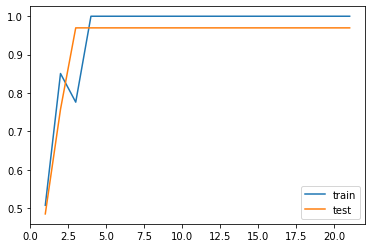

In [107]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
Ada = AdaBoost_DT(n_estimators = 20)
Ada.fit(X_train,y_train,max_depth = 5)
Ada.history(X_train,y_train,X_test,y_test)

# comparison for different max_depth

In [115]:
import datetime

# max_depth = 5

In [116]:
start = datetime.datetime.now()
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost_DT(n_estimators=5)
    clf.fit(X_train, y_train,max_declining_value = 0.1,early_stopping_value = 0.88,max_depth = 5)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    #print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))
end = datetime.datetime.now()
print (end-start)

average score:0.925 std:0.059
0:00:02.231830


# No max_depth

In [117]:
start = datetime.datetime.now()
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost_DT(n_estimators=5)
    clf.fit(X_train, y_train,max_declining_value = 0.1,early_stopping_value = 0.88)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    #print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))
end = datetime.datetime.now()
print (end-start)

average score:0.942 std:0.033
0:00:03.260829


# max_depth=3

In [126]:
start = datetime.datetime.now()
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost_DT(n_estimators=5)
    clf.fit(X_train, y_train,max_declining_value = 0.1,early_stopping_value = 0.88,max_depth = 3)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    #print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))
end = datetime.datetime.now()
print (end-start)

average score:0.828 std:0.063
0:00:02.087816


# max_depth = 2

In [127]:
start = datetime.datetime.now()
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost_DT(n_estimators=5)
    clf.fit(X_train, y_train,max_declining_value = 0.1,early_stopping_value = 0.88,max_depth = 2)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    #print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))
end = datetime.datetime.now()
print (end-start)

average score:0.796 std:0.066
0:00:01.789997


# stump

In [128]:
start = datetime.datetime.now()
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost_DT(n_estimators=5)
    clf.fit(X_train, y_train,max_declining_value = 0.1,early_stopping_value = 0.88,max_depth = 1)
    r = clf.score(X_test, y_test)
    #clf.history(X_train,y_train,X_test, y_test)
    #print('{}/100 score：{}'.format(i, r))
    result.append(r)
print('average score:{:.3f} std:{:.3f}'.format(np.mean(result),np.std(result,ddof=1)))
end = datetime.datetime.now()
print (end-start)

average score:0.810 std:0.055
0:00:01.102373
